# Unsupervised and supervised analysis of protein sequences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

## Task 1: One-hot encoding of protein sequence data

First of all, we extract the data and obtain a vector of sequences. Each sequence, as the text of the exercise says, is composed of 96 amino acids from the list {A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y}. 

In [2]:
nat_data = open('MSA_nat.txt','r')
nat_lines = nat_data.readlines()
nat_seqs = []
for i in range(0,len(nat_lines)):
    if i%4 == 1:
        new_line = nat_lines[i]+nat_lines[i+1]
        nat_seqs.append(new_line.replace('\n',''))

gen_data = open('MSA_gen.txt','r')
gen_lines = gen_data.readlines()
gen_seqs = []
for i in range(0,len(gen_lines)):
    if i%4 == 1:
        new_line = gen_lines[i]+gen_lines[i+1]
        gen_seqs.append(new_line.replace('\n',''))

Then, we apply a slight variant of the one-hot encoding method, substituting to each letter in the sequences a 20 component vector of the type (1,0,...,0), where the position of the 1 denotes the corresponding amino acid. Here we define a function that returns the position of the letter of a sequence. 

In [3]:
def position(S):
    pos = np.zeros(len(S))
    aminos = ['A','C','D','E','F','G','H','I','K','L','M','N',
              'P','Q','R','S','T','V','W','Y','-']
    for j in range(0,len(S)):
        for i in range(0,len(aminos)):
            if S[j] == aminos[i]:
                pos[j] = i
    return pos

Now, having associated a position to each aminoacid, we can substitute it with the 20 components vector, obtaining sequences of 1920 components. 

In [4]:
new_nat_data = np.empty((len(nat_seqs),1920))

for i in range(0,len(nat_seqs)):
    new_line = []
    pos = position(nat_seqs[i])
    for j in range(0,len(pos)):
        index = pos[j]
        sub = np.zeros(20)
        if index != 20:
            sub[int(index)] = 1
        new_line.extend(sub)
    new_nat_data[i,:] = new_line

new_gen_data = np.empty((len(gen_seqs),1920))

for i in range(0,len(gen_seqs)):
    new_line = []
    pos = position(gen_seqs[i])
    for j in range(0,len(pos)):
        index = pos[j]
        sub = np.zeros(20)
        if index != 20:
            sub[int(index)] = 1
        new_line.extend(sub)
    new_gen_data[i,:] = new_line

## Task 2: Dimensional reduction and visualization of sequence space

The one-hot encoding representation dramatically increases the number of features for each sequence, making it quite useful to perform dimensional reduction. One of the most known and easy algorithm is the Principal Component Analysis, also called PCA. This method consists in the projection of the data along the eigenvectors of the covariance matrix having largest eigenvalues. In fact, the magnitude of the eigenvalues corresponds to the variance of that features, and high variance usually means large information. We will extract the first 3 principal components, then plot the data in 2D and in 3D. This will allow us to observe the spatial distribution of the data and to check if any crowding is happening. 

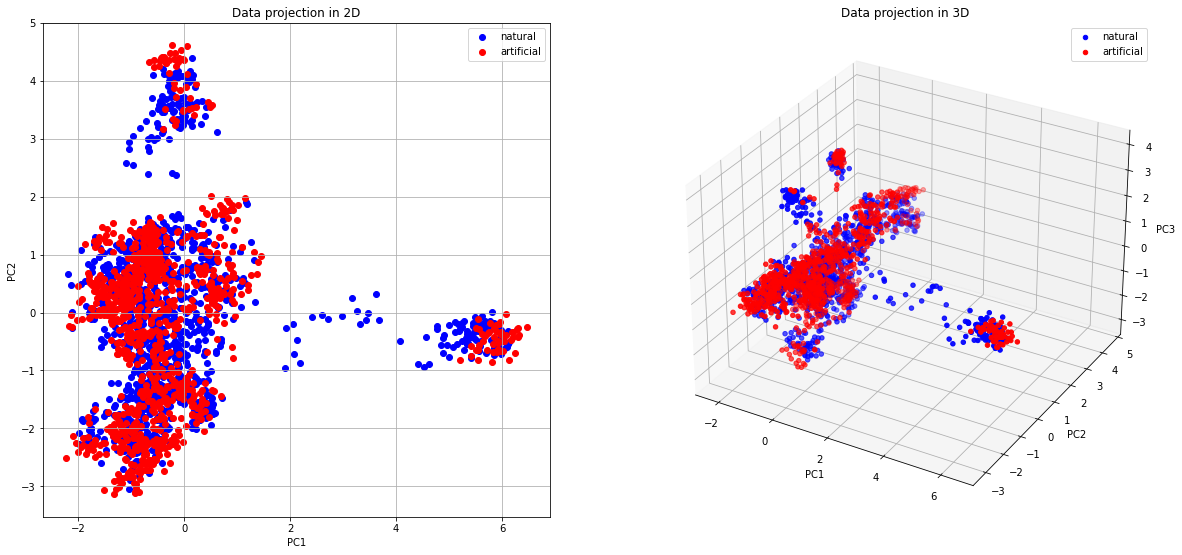

In [20]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection = '3d')

PCA_model = PCA(n_components = 3)

nat_fit = PCA_model.fit_transform(new_nat_data)
gen_fit = PCA_model.transform(new_gen_data)

ax1.scatter(nat_fit[:,0],nat_fit[:,1],color = 'blue',label = 'natural')
ax2.scatter(nat_fit[:,0],nat_fit[:,1],nat_fit[:,2],color = 'blue',label = 'natural')
ax1.scatter(gen_fit[:,0],gen_fit[:,1],color = 'red',label = 'artificial')
ax2.scatter(gen_fit[:,0],gen_fit[:,1],gen_fit[:,2],color = 'red',label = 'artificial')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax1.set_title('Data projection in 2D')
ax2.set_title('Data projection in 3D')

ax1.grid()
ax1.legend()
ax2.legend()
plt.show()

From these figures we can already see how sequences are distributed in space. The 2D projection shows three main clusters, whereas the 3D reveals that we can identify at least 5 clusters. This tells us how crowding has a decisive role in the projection of these data. Squeezing togheter data which were far apart in the 3D projection, we lose a good amount of information. We will see how this will affect the functionality segregation in the following. Moreover, we observe how natural and artificial sequences occupy approximatively the same regions in space, even though articial sequences seem to exhibit less variance. In the following we want to understand how sequences are distributed in space according to their functionality. We consider separately artificial and natural sequences.  

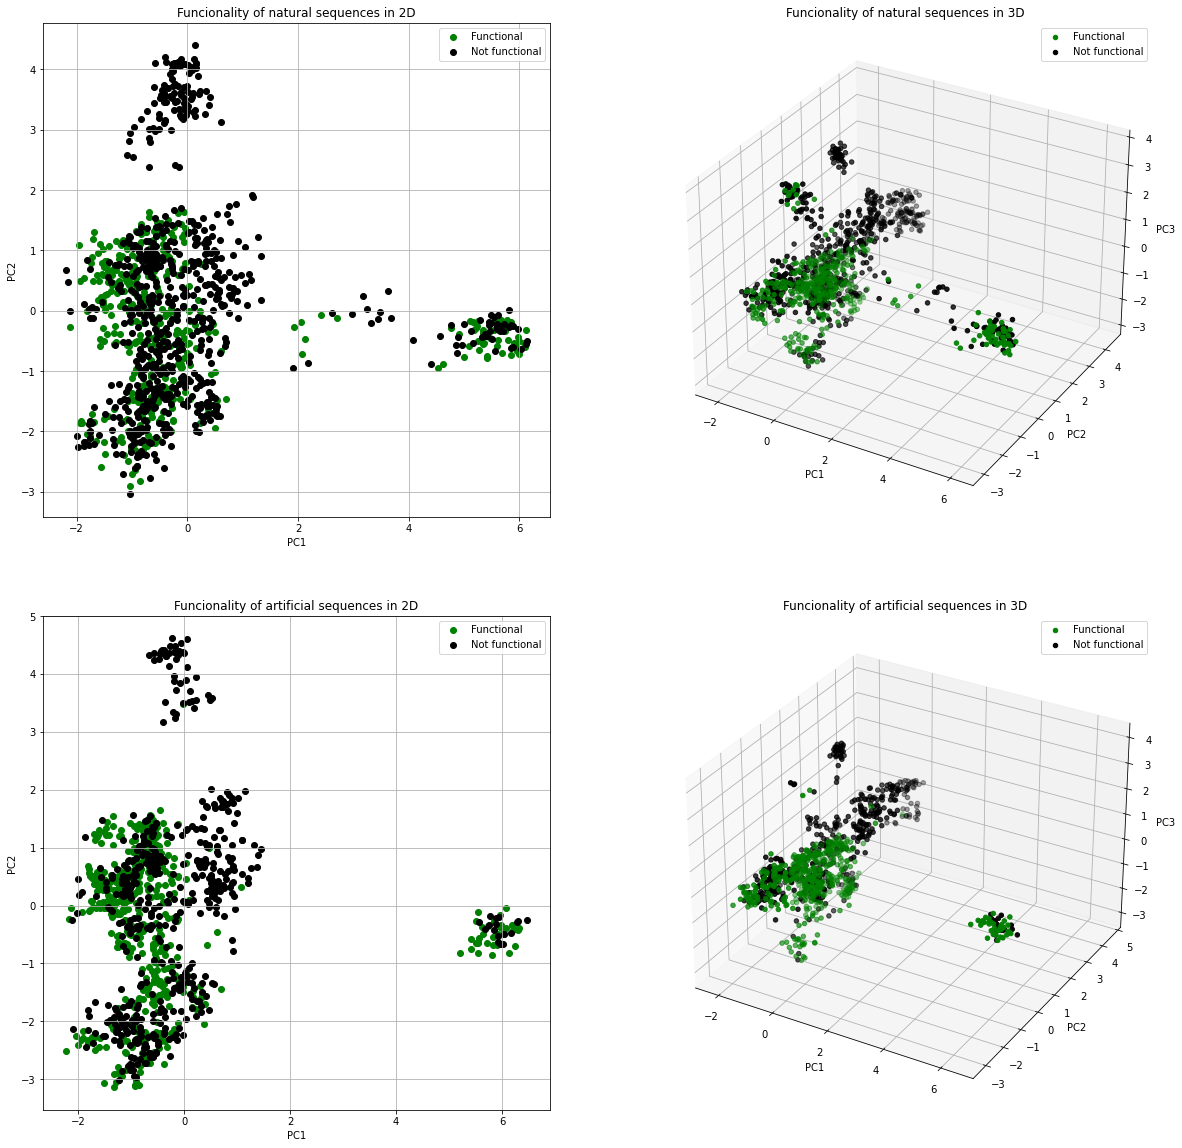

In [6]:
nat_funs = np.zeros(1130)

for i in range(0,1130):
    x = 'true'
    y = nat_lines[i*4]
    if x in y:
        nat_funs[i] = 1
        
life_nat = (nat_funs==1.)
dead_nat = (nat_funs==0.)

gen_funs = np.zeros(len(new_gen_data[:,0]))

for i in range(0,len(new_gen_data[:,0])):
    x = 'true'
    y = gen_lines[i*4]
    if x in y:
        gen_funs[i] = 1

life_gen = (gen_funs==1.)
dead_gen = (gen_funs==0.)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection = '3d')
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224, projection = '3d')
ax1.scatter(nat_fit[life_nat,0], nat_fit[life_nat,1],color='green', label='Functional')
ax1.scatter(nat_fit[dead_nat,0], nat_fit[dead_nat,1],color='black', label='Not functional')
ax2.scatter(nat_fit[life_nat,0], nat_fit[life_nat,1],nat_fit[life_nat,2],color='green', label='Functional')
ax2.scatter(nat_fit[dead_nat,0], nat_fit[dead_nat,1],nat_fit[dead_nat,2],color='black', label='Not functional')
ax1.grid()
ax1.set_title('Funcionality of natural sequences in 2D')
ax2.set_title('Funcionality of natural sequences in 3D')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax3.scatter(gen_fit[life_gen,0], gen_fit[life_gen,1],color='green', label='Functional')
ax3.scatter(gen_fit[dead_gen,0], gen_fit[dead_gen,1],color='black', label='Not functional')
ax4.scatter(gen_fit[life_gen,0], gen_fit[life_gen,1],gen_fit[life_gen,2],color='green', label='Functional')
ax4.scatter(gen_fit[dead_gen,0], gen_fit[dead_gen,1],gen_fit[dead_gen,2],color='black', label='Not functional')
ax3.grid()
ax3.set_title('Funcionality of artificial sequences in 2D')
ax4.set_title('Funcionality of artificial sequences in 3D')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax4.set_xlabel('PC1')
ax4.set_ylabel('PC2')
ax4.set_zlabel('PC3')


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

As the set of figures show, sequences functionality and their position in space are correlated only in some regions. Both the 2D and the 3D projections show a non functional group located at large values of PC2, suggesting that this component might be related to the functionality properties of the sequences more than the others. On the other hand, the central cluster appears mixed in both representations, even if the 3D case shows a more definite segregation. Finally, the small cluster at around 6 in PC1 appears to be made of sequences of both functionalities without a definite preference. 

## Task 3: Clustering sequence data

A simple visual inspection of the functionality distribution in space could not tell us much. To have a deeper insight into the spatial correlation between sequences of the same nature we try to use a clustering procedure. Among the many clustering algorithms we choose K-means, that allows us to choose the number of clusters we desire. 

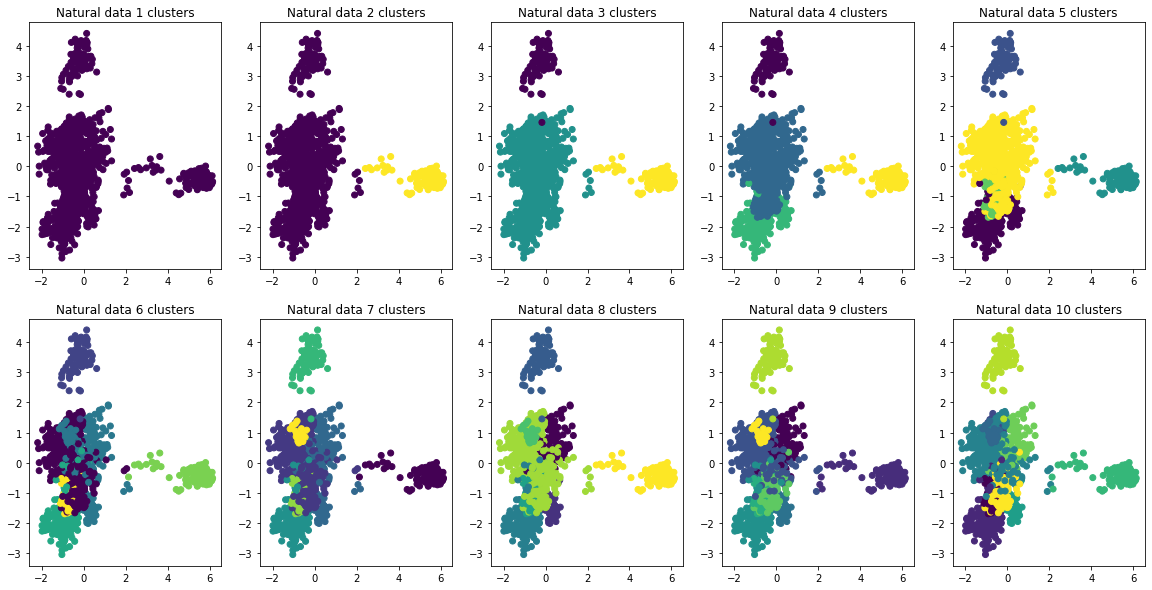

In [7]:
nat_data = new_nat_data

K_range = np.arange(10).reshape(2,5)
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1],figsize= (20,10))

save_labels=[]
for i in range(K_range.shape[0]):
    for j in range(K_range.shape[1]):
        k_model = KMeans(n_clusters=K_range[i,j]+1,n_init = 200)
        k_model.fit(nat_data)
        nat_y = k_model.labels_
        save_labels.append(nat_y)
        fit_nat_data = PCA_model.transform(nat_data)
        ax[i,j].scatter(fit_nat_data[:,0],fit_nat_data[:,1], c=nat_y)
        ax[i,j].set_title('Natural data %i clusters'%(K_range[i,j]+1))

To ensure a precise result of the clustering algorithm we used a large number of initializations, trading off some computational efficiency. This, however, ensures the best results especially in those region where sequences are very close to each other. We observe how, for 3 clusters, we find correspondence with the visual analysis we conducted previously. Then, when the number of cluster increases, crowding effects start to be visible, making it harder to distinguish between single clusters. However, the top and right small clusters remain well identified, confirming our hypothesis about their relevance. To have a better and more quantitative idea about functionality segregation in the cluster we found, we will now compute the distribution of functions inside each cluster. This is a number between 0 and 1, and the closer it is to one of the two extrema, the more the cluster contains sequences with the same functionality.  

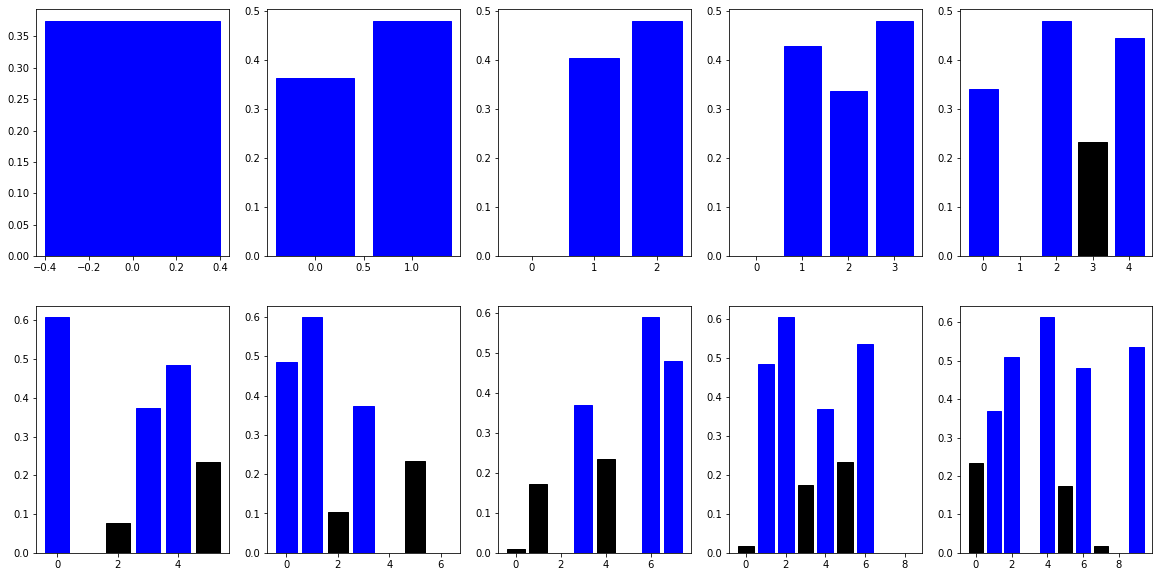

In [8]:
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1],figsize= (20,10))

for i in range(0,len(save_labels)):
    labels = save_labels[i]
    prop = np.empty(i+1)
    for j in range(0,i+1):
        cluster = (labels == j)
        prop[j] = np.average(nat_funs[cluster])
    barlist = ax[i//5,i%5].bar(range(0,i+1),prop)
    for k in range(0,len(barlist)):
        if prop[k] > 0.75:
            barlist[k].set_color('green')
        elif prop[k] <0.25:
            barlist[k].set_color('black')
        else:
            barlist[k].set_color('blue')

We used colors to denote the functionality of each cluster. We set a threshold of 0.75 for a cluster to be functional and of 0.25 for it to be considered not functional. Black cluster are the non functional whereas green denotes functional ones. We observe how, starting from a clustering with 3 centers, we already have a perfectly segregated cluster, that corresponds to the small top cluster we have already identified. Then, as the number of clusters increas, so does the number of non functional clusters, having 5 of them in the case of 10 clusters. This surely shows a certain correlation among non functional sequences. We are not so happy about the functional clusters though. It appears indeed that non of the cluster found by the algorithm has a functional prevalence. 
We now conduct the same analysis for the set of all sequences, hoping that this will shed more light on the matter. 

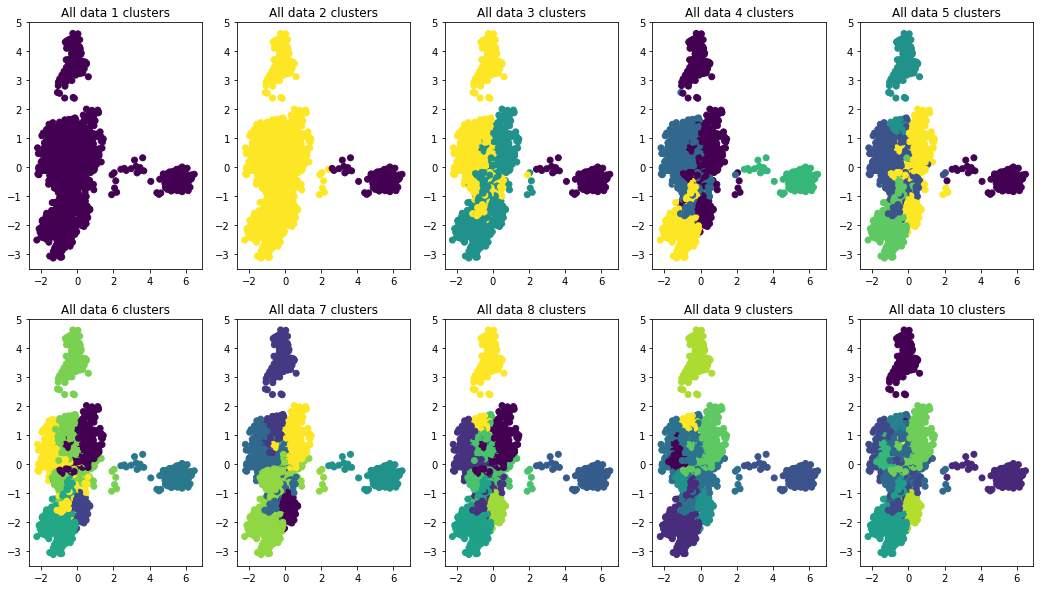

In [9]:
n_nat = np.shape(new_nat_data)[0]
n_gen = np.shape(new_gen_data)[0]
n_cols = np.shape(new_nat_data)[1]
all_data = np.empty((n_nat + n_gen,n_cols))

all_data[:n_nat,:] = new_nat_data
all_data[n_nat:,:] = new_gen_data

K_range = np.arange(10).reshape(2,5)
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1],figsize= (18,10))

save_all_labels=[]
for i in range(K_range.shape[0]):
    for j in range(K_range.shape[1]):
        all_k_model = KMeans(n_clusters=K_range[i,j]+1,n_init = 200)
        all_k_model.fit(all_data)
        all_y = all_k_model.labels_
        save_all_labels.append(all_y)
        fit_all_data = PCA_model.transform(all_data)
        ax[i,j].scatter(fit_all_data[:,0],fit_all_data[:,1], c=all_y)
        ax[i,j].set_title('All data %i clusters'%(K_range[i,j]+1))

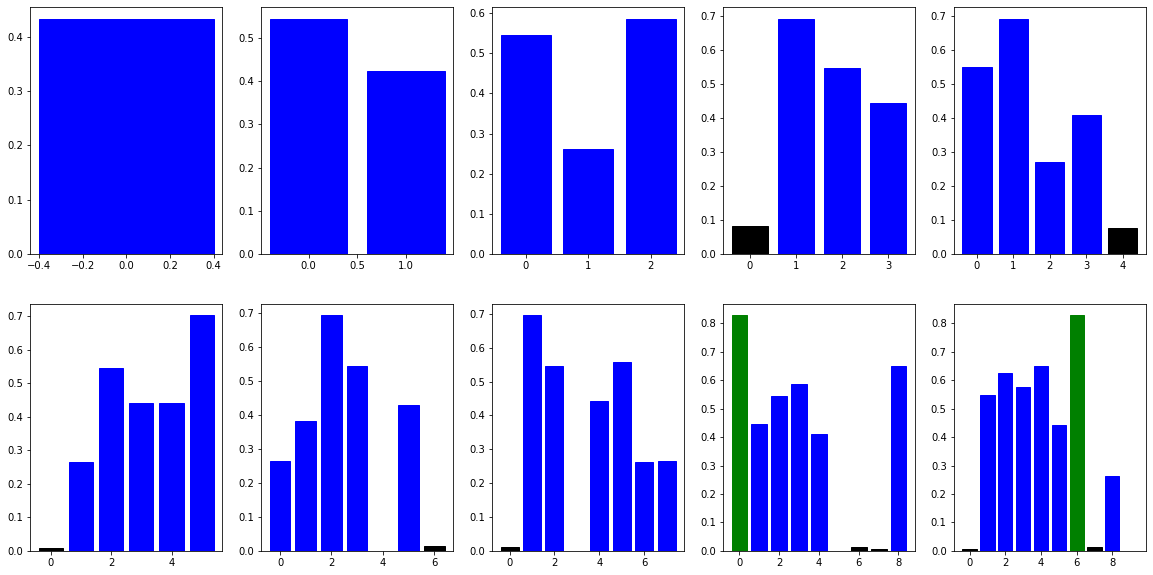

In [10]:
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1],figsize= (20,10))

all_funs = np.concatenate((nat_funs,gen_funs))

for i in range(0,len(save_all_labels)):
    labels = save_all_labels[i]
    prop = np.empty(i+1)
    for j in range(0,i+1):
        cluster = (labels == j)
        prop[j] = np.average(all_funs[cluster])
    barlist = ax[i//5,i%5].bar(range(0,i+1),prop)
    for k in range(0,len(barlist)):
        if prop[k] > 0.75:
            barlist[k].set_color('green')
        elif prop[k] <0.25:
            barlist[k].set_color('black')
        else:
            barlist[k].set_color('blue')

Considering all data together has indeed brought some change, in that we now observe the appearance of functional clusters. Non functional ones are still present already with a small number of centers, but at 7 centers we see the first functional cluster. The differentiation continues as the number of clusters increases, and at 10 we have 5 differentiated clusters, letting us presume that increasing the number of centers would give more segregated clusters. 

## Task4: Predicting protein functionality

At this point, we are asked to use a classifier to predict protein functionality. First of all, we must choose the model. Since we are dealing with categorical data, we choose to use a logistic regression algorithm. We mustchoose the regularization parameter that gives the best trade-off between bias and variance of the model. Infact, we don't want a model that learns the data too perfectly, because it might not be good at generalizing. We will use the natural sequences as training dataset, and the artificial ones as test set. Learning the training data too good could mean also having learnt the noise of single data points, which is not good for predicting. In the following we show the accuracy of the model both on the training and the test set.

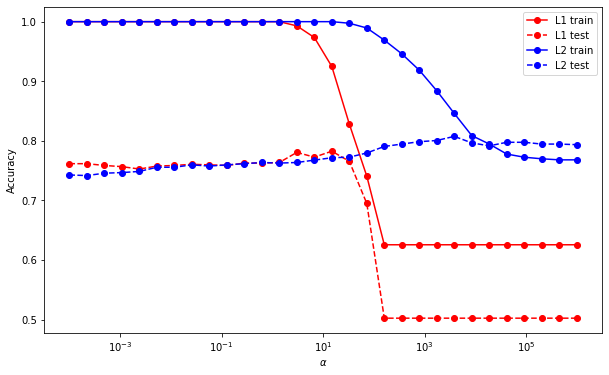

In [11]:
fig = plt.figure(figsize=(10,6))

# Choose training and test dataset

x_train = StandardScaler().fit_transform(new_nat_data)
y_train = nat_funs
x_test = StandardScaler().fit_transform(new_gen_data)
y_test = gen_funs

alphas = np.logspace(-4,6,30)

# L1 regularization

l1_train_accuracy = []
l1_test_accuracy = []

for alpha in alphas:
    model = linear_model.LogisticRegression(penalty='l1',C=1.0/alpha, solver='liblinear')
    model.fit(x_train,y_train)
    l1_train_accuracy.append(model.score(x_train,y_train))
    l1_test_accuracy.append(model.score(x_test,y_test))
    
plt.semilogx(alphas,l1_train_accuracy,'-o',color = 'red',label = 'L1 train')
plt.semilogx(alphas,l1_test_accuracy,'--o',color = 'red',label='L1 test')

# L2 regularization

l2_train_accuracy = []
l2_test_accuracy = []

for alpha in alphas:
    model = linear_model.LogisticRegression(penalty='l2',C=1.0/alpha, solver='liblinear')
    model.fit(x_train,y_train)
    l2_train_accuracy.append(model.score(x_train,y_train))
    l2_test_accuracy.append(model.score(x_test,y_test))
    
plt.semilogx(alphas,l2_train_accuracy,'-o',color = 'blue',label = 'L2 train')
plt.semilogx(alphas,l2_test_accuracy,'--o',color = 'blue',label='L2 test')

plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

The previous figure shows how a good trade-off between accuracy in the training and in the test is reached for $\alpha= 10^3$ in a model with L2 regularization. We can justify this better by considering the number of true predictions. We will now, in fact, predict labels for the artificial sequences, and, comparing them with the artificial labels, we define four possible outcomes: true positive (TP), true negative(TN), false positive (FP), false negative (FN). 

In [12]:
def preds(predictions):
    tp, tn, fp, fn = 0,0,0,0
    for i in range(0,len(predictions)):
        if predictions[i] == gen_funs[i]:
            if predictions[i] ==1:
                tp +=1
            else:
                tn +=1
        else:
            if predicted[i] ==1:
                fp +=1
            else:
                fn +=1
    return [tp, tn, fp, fn]

We now compute the sum of true predicted values, for the same different values of the regularization that we have used before and for both the regularization methods.

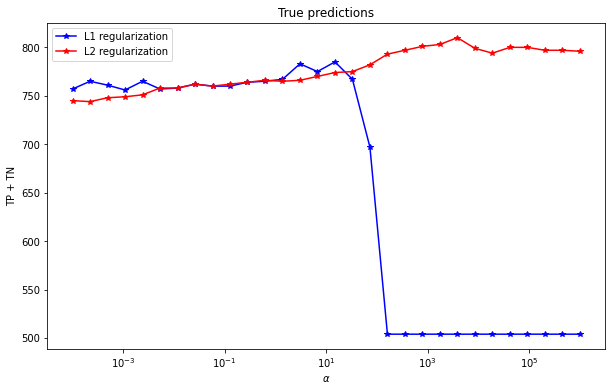

In [13]:
fig = plt.figure(figsize=(10,6))
plt.title('True predictions')
plt.ylabel('TP + TN')
plt.xlabel(r'$\alpha$')

true_preds_1 = []

for alpha in alphas:
    pred_model = linear_model.LogisticRegression(penalty='l1',C=1.0/alpha, solver='liblinear')
    pred_model.fit(x_train,y_train)
    predicted = pred_model.predict(x_test)
    pr = preds(predicted)
    true_preds_1.append(pr[0]+pr[1])

plt.semilogx(alphas,true_preds_1,'-*',color = 'blue',label = 'L1 regularization')

true_preds_2 = []

for alpha in alphas:
    pred_model = linear_model.LogisticRegression(penalty='l2',C=1.0/alpha, solver='liblinear')
    pred_model.fit(x_train,y_train)
    predicted = pred_model.predict(x_test)
    pr = preds(predicted)
    true_preds_2.append(pr[0]+pr[1])
    
plt.semilogx(alphas,true_preds_2,'-*',color = 'red',label = 'L2 regularization')

plt.legend()
plt.show()

The graph confirms indeed that the best logistic regression model is one with an L2 regularization with strength $\alpha = 10^3$. We use this model and print all the possible outcomes. 

In [14]:
alpha = 10**3

final = linear_model.LogisticRegression(penalty='l2',C=1.0/alpha, solver='liblinear')
final.fit(x_train,y_train)
predicted = final.predict(x_test)
pr = preds(predicted)

print('We have ', pr[0], ' true positive.')
print('We have ', pr[1], ' true negative.')
print('We have ', pr[2], ' false positive.')
print('We have ', pr[3], ' false negative.')

We have  390  true positive.
We have  415  true negative.
We have  89  false positive.
We have  109  false negative.
